#  Classification Model
El objetivo de este proyecto es poder clasificar los días festivos utilizando las variables "Markdowns". Los datos fueron obtenidos de: https://www.kaggle.com/datasets/manjeetsingh/retaildataset?select=stores+data-set.csv

In [1]:

# Data manipulation
import pandas as pd
import numpy as np

# Graphs
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Model
import xgboost as xgb

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix as cm, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

#  Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE

Mounted at /content/drive


In [2]:
from sklearn.metrics import ConfusionMatrixDisplay

### Load Data

In [3]:
# Datasets
feature = pd.read_csv('Features data set.csv')

In [4]:
# Visualization a sample of data
display(feature.sample(5))

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
4898,27,12/04/2013,53.28,3.914,9303.85,6759.23,74.36,2471.53,1389.71,143.220074,7.697,False
4920,28,19/03/2010,59.57,3.054,NaN,NaN,NaN,NaN,NaN,126.606645,13.975,False
4896,27,29/03/2013,41.53,3.983,9272.92,NaN,863.54,3.76,4253.53,143.090106,7.945,False
1093,7,12/02/2010,25.90,2.572,NaN,NaN,NaN,NaN,NaN,189.464272,9.014,True
5121,29,30/07/2010,76.35,2.792,NaN,NaN,NaN,NaN,NaN,132.598387,10.409,False


In [5]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB




---


We can see that the data set has null values. Now we have to check how many there are in total.


---



In [7]:
feature.isnull().sum()

,0
Store,0
Date,0
Temperature,0
Fuel_Price,0
MarkDown1,4158
MarkDown2,5269
MarkDown3,4577
MarkDown4,4726
MarkDown5,4140
CPI,585




---


In general, the features Markdown1, Markdown2, Markdown3, Markdown4 and Markdown5 contain a significant number of null values (slightly more than 50%, totaling 8190 records). Therefore, it is necessary to clean this data set.

Moreover, some data types need to be changed.


---



In [12]:
# Change data types
feature['Date'] = pd.to_datetime(feature['Date'], format='%d/%m/%Y')

### EDA

In [13]:
# Feature
len_dates_features = len(feature['Date'].unique())
print('unique dates {}'.format(len_dates_features))
print('min: {}'.format(feature['Date'].min()))
print('max: {}'.format(feature['Date'].max()))

unique dates 182
min: 2010-02-05 00:00:00
max: 2013-07-26 00:00:00


In [14]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [15]:
feature[feature['Date'] < '2011-10-31'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4095 entries, 0 to 8098
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         4095 non-null   int64         
 1   Date          4095 non-null   datetime64[ns]
 2   Temperature   4095 non-null   float64       
 3   Fuel_Price    4095 non-null   float64       
 4   MarkDown1     0 non-null      float64       
 5   MarkDown2     0 non-null      float64       
 6   MarkDown3     0 non-null      float64       
 7   MarkDown4     0 non-null      float64       
 8   MarkDown5     0 non-null      float64       
 9   CPI           4095 non-null   float64       
 10  Unemployment  4095 non-null   float64       
 11  IsHoliday     4095 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 387.9 KB





---


Before October 2011, the markdown features are not available. This is important
because a machine learning model will be built using the features Markdown1, Markdown2, Markdown3, Markdown4, and Markdown5


---





In [16]:
# Remove null data from feature dataset
feature_nonulls = feature.dropna()

In [17]:
# Create a new dataset only with:
# Markdown1, Markdown2,..., Markdown5 ans IsHoliday
markdowns_isHoliday = feature_nonulls.iloc[:, list(range(4, 9)) + [11]]

 * Bar graphs



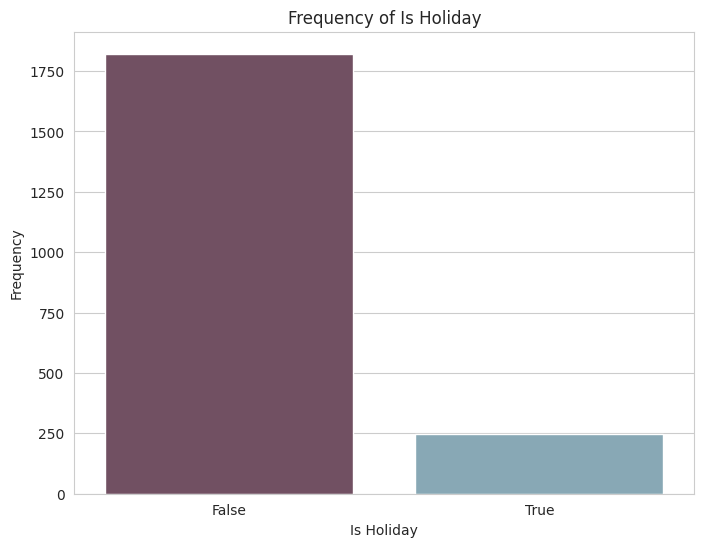

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.countplot(x='IsHoliday', data=markdowns_isHoliday,
              palette=['#774a62', '#81abbc'])
plt.xlabel('Is Holiday')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['False', 'True'], rotation=0)
plt.title('Frequency of Is Holiday')
plt.show()

* Pairplot

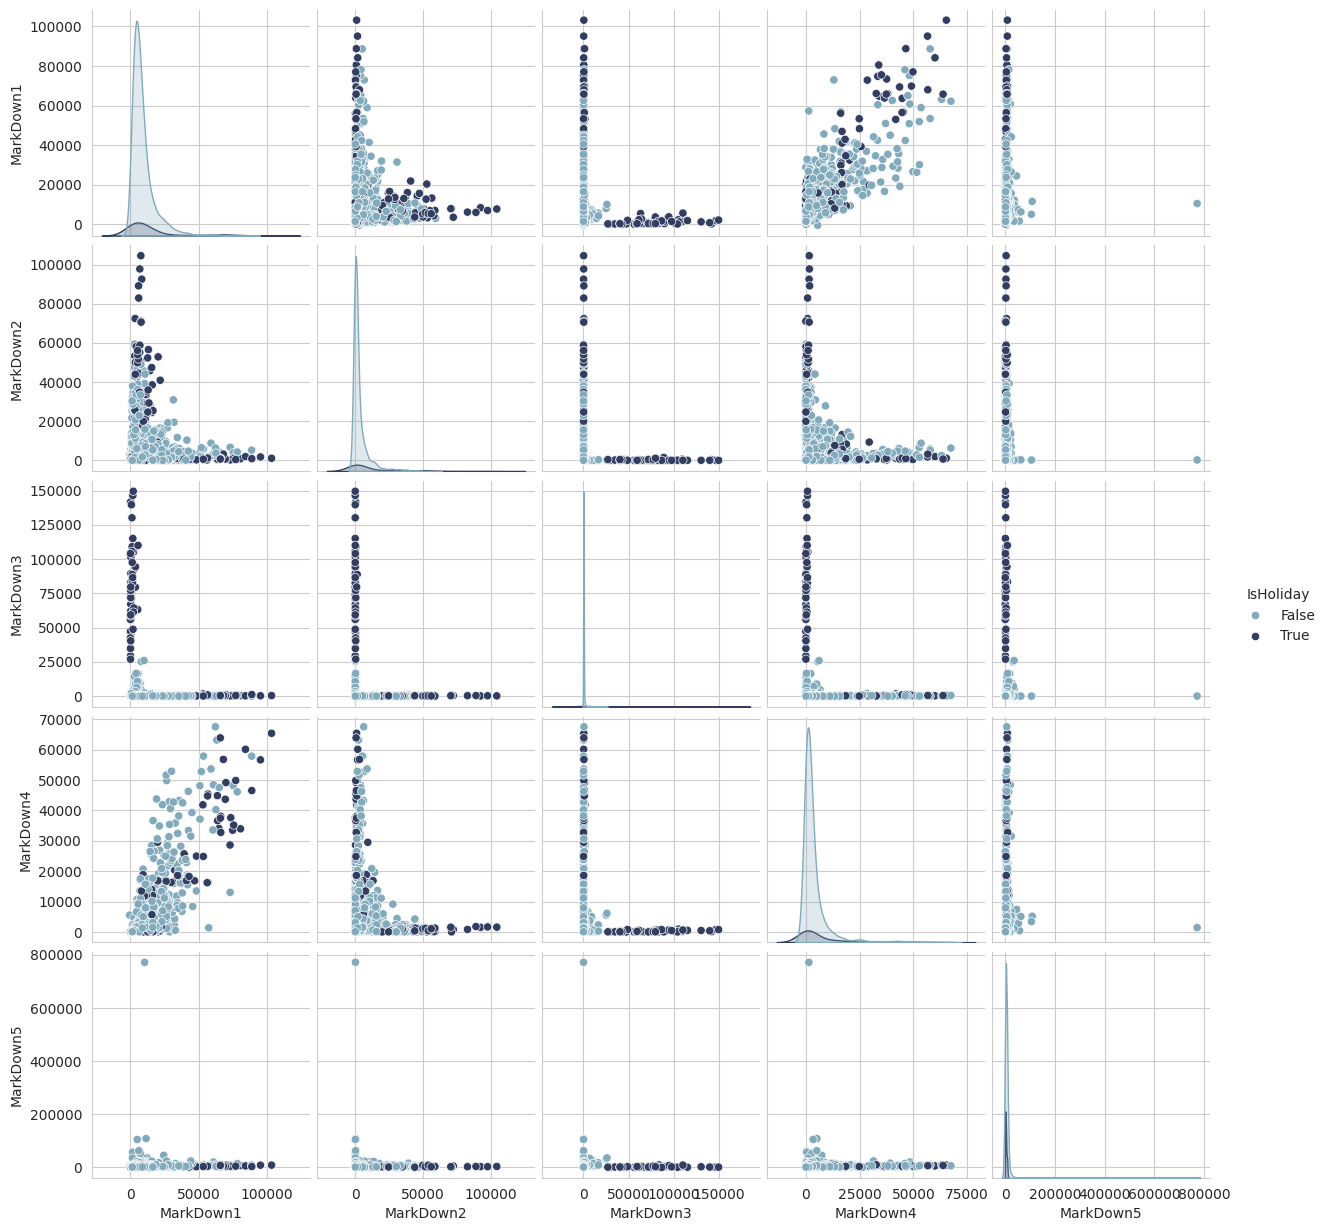

In [19]:
colors = ['#81abbc', '#313e61']
sns.set_style("whitegrid")
sns.pairplot(markdowns_isHoliday, hue='IsHoliday', palette=colors)



---



We can observe the relationships between the different features. In general, there is no clear relationship, except for Markdown1 and Markdown4, which seem to have a linear relationship. Additionally, we can see that the variables Markdown1, Markdown2, Markdown4, and Markdown5 show greater dispersion on holidays compared to non-holidays.


---



* Distribution for ecah feature

In [20]:
columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
aux = markdowns_isHoliday.to_numpy()

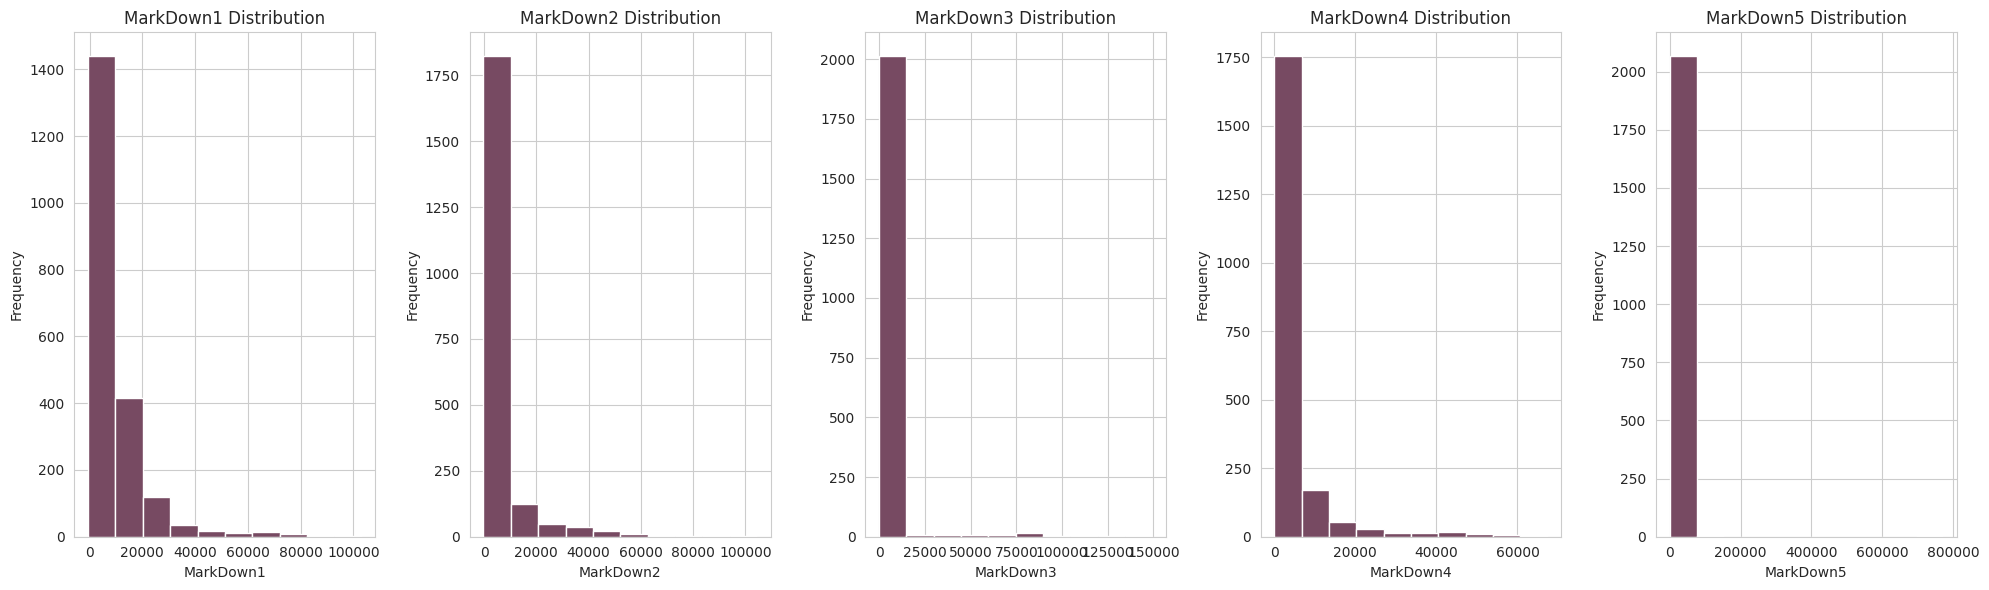

In [21]:
sns.set_style("whitegrid")
num_vars = len(columns)
fig, axes = plt.subplots(ncols=num_vars, figsize=(20, 6))


for i, col in enumerate(columns):
    axes[i].hist(aux[:, i], color='#774a62')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

* Distribution of each variable with respect to whether it is a holiday or not

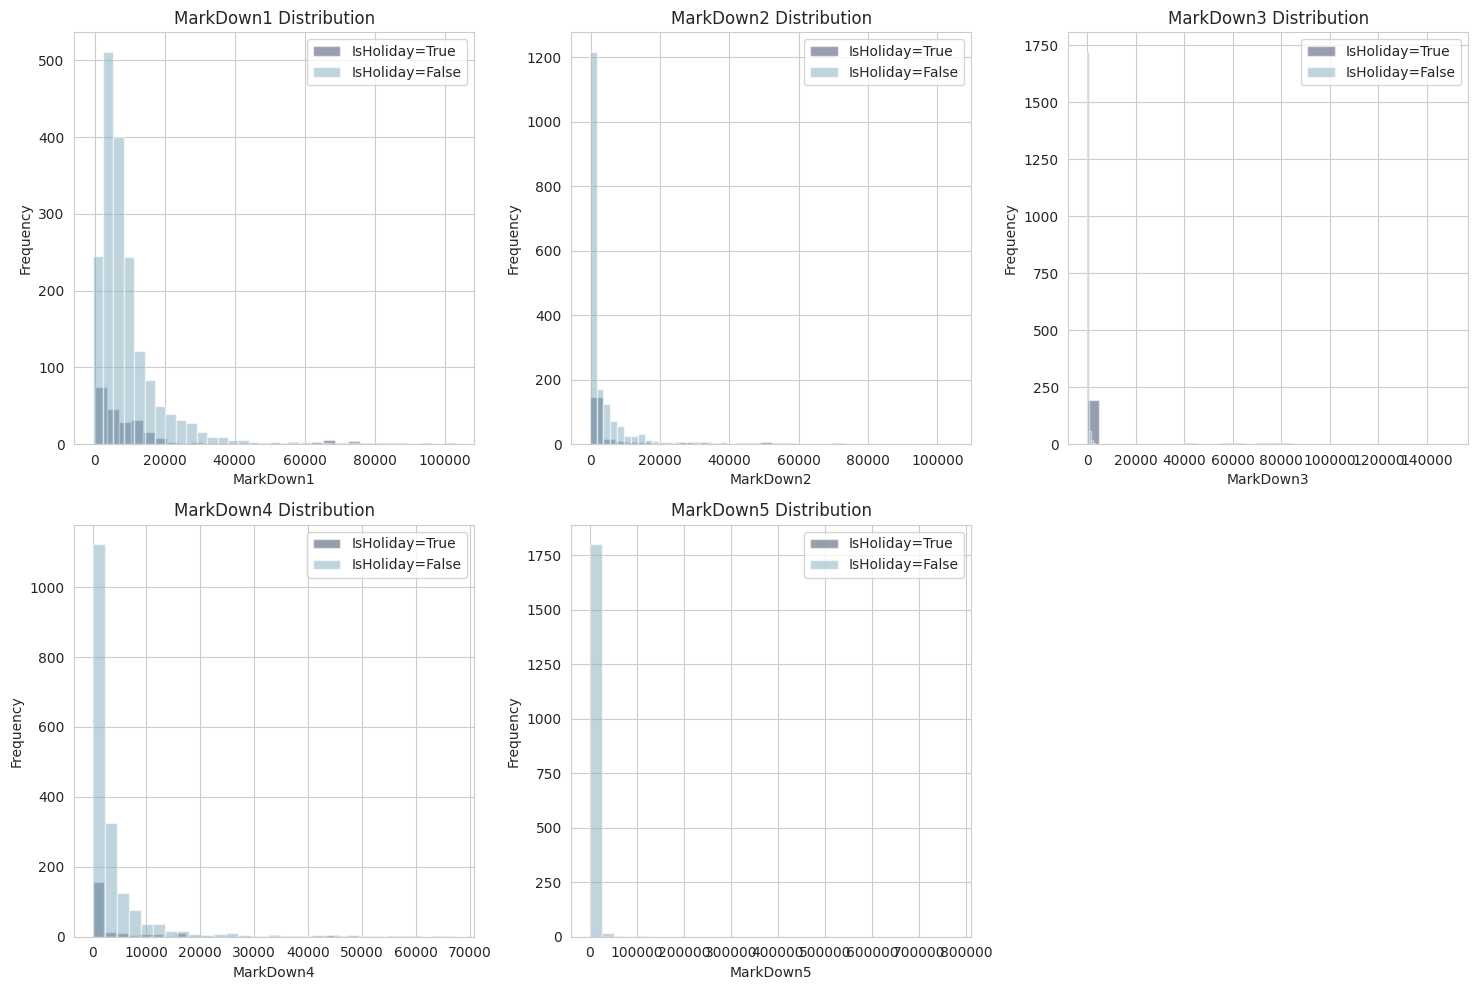

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
colors=['#81abbc', '#313e61']

for i, col in enumerate(columns):
    plt.subplot(2, 3, i+1)
    for holiday in [True, False]:
        subset = markdowns_isHoliday[markdowns_isHoliday['IsHoliday'] == holiday][col]
        plt.hist(subset, bins=30, alpha=0.5, label=f'IsHoliday={holiday}', color=colors[holiday])

    plt.title(f'{col} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()



---


This chart makes it easier to see the difference between holidays and non-holidays, although it's a bit difficult to discern what is happening with the Markdown5 function.


---



* Boxplot

In [23]:
aux = markdowns_isHoliday.copy()
aux['IsHoliday'] = aux['IsHoliday'].apply(lambda x: 'Is Holiday' if x == True else 'Not Holiday')

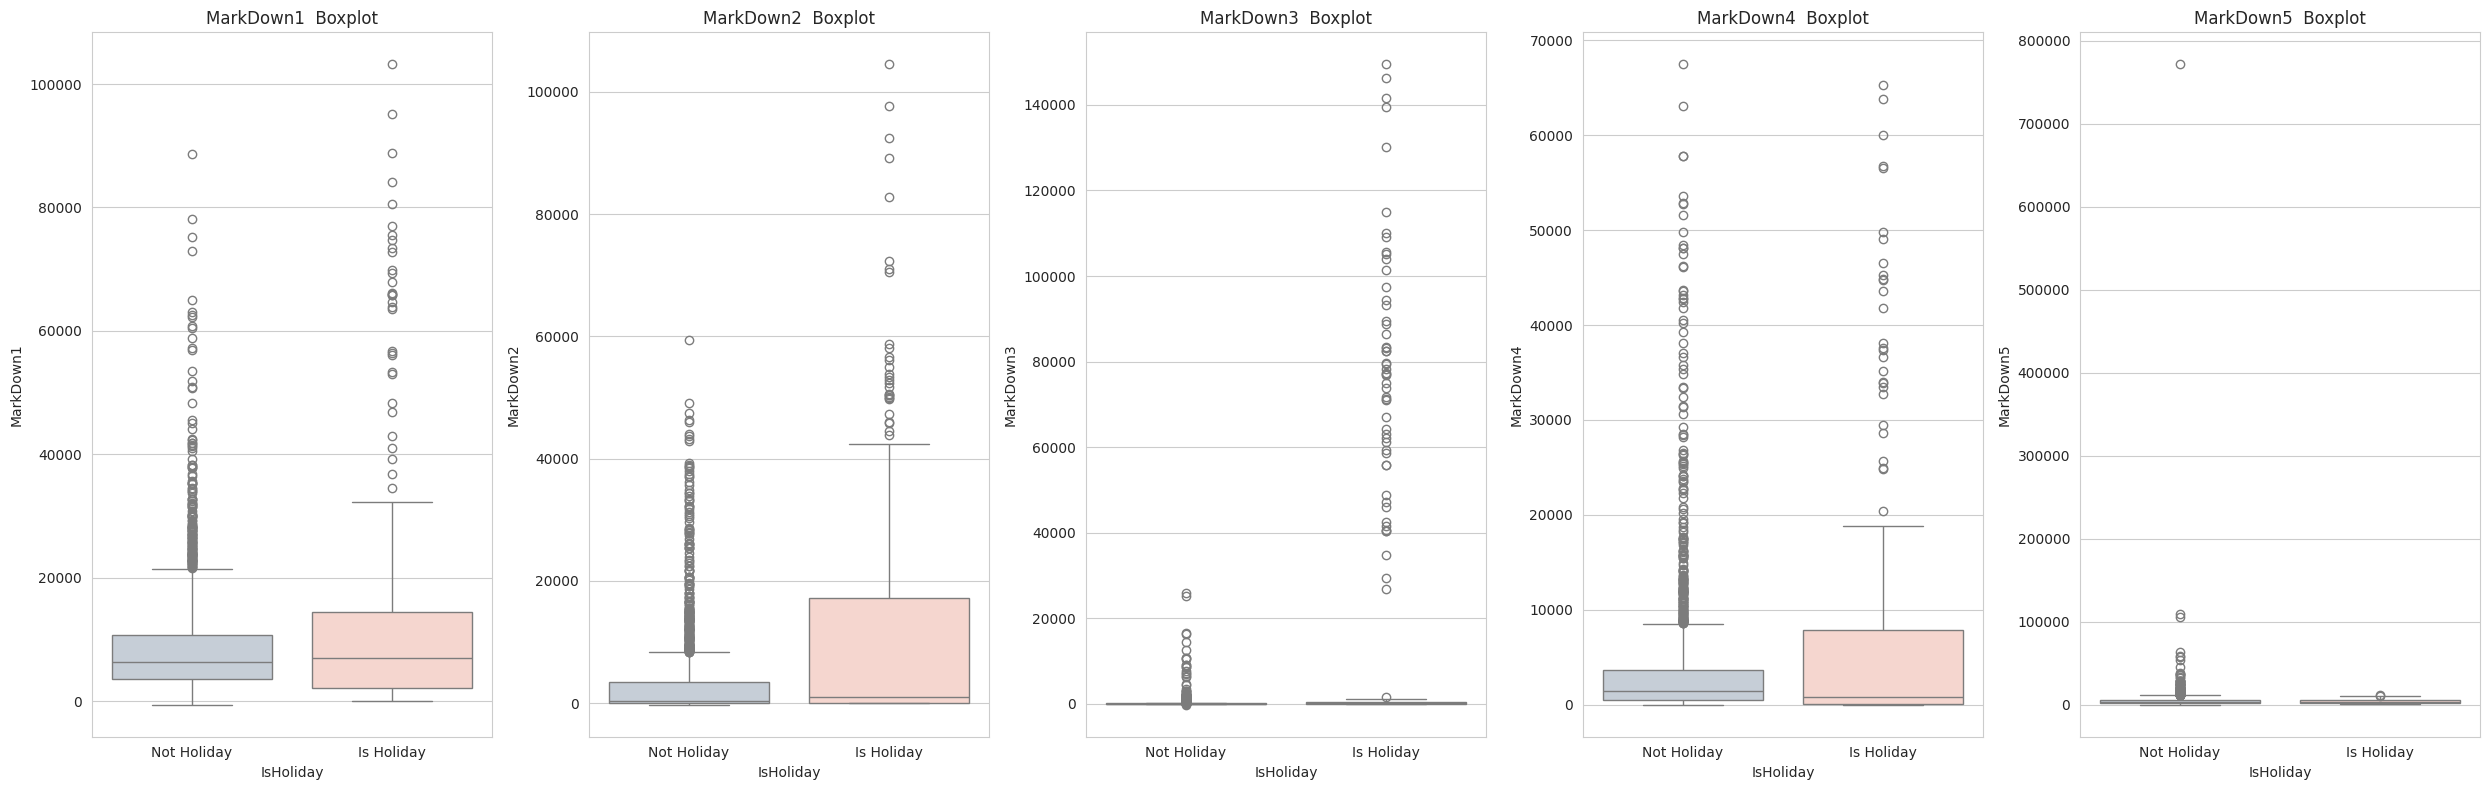

In [24]:
sns.set_style("whitegrid")
palette =  {'Not Holiday': "#c3ceda", 'Is Holiday': "#fbd2c9"}

fig, axes = plt.subplots(ncols=num_vars, figsize=(25, 8))


for i, col in enumerate(columns):
    sns.boxplot(data=aux, x='IsHoliday', y=col, ax=axes[i], palette=palette)
    axes[i].set_title(f'{col}  Boxplot')



plt.tight_layout()
plt.show()

In [25]:
markdowns_isHoliday.describe()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
count,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000
mean,9717.665297,4426.859778,2247.535911,4213.162687,5056.916061
std,11377.636869,10154.658061,13305.985612,8359.765985,17807.168442
min,-563.900000,-265.760000,-179.260000,0.460000,-185.170000
25%,3542.800000,67.990000,5.840000,404.050000,2014.840000
50%,6397.720000,404.610000,34.100000,1401.230000,3470.490000
75%,11265.620000,3900.310000,137.990000,3834.440000,5674.110000
max,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000




---

As we can see, the dataset has many outliers. For this reason, the IQR method will be used to avoid having noise in the model.

---




In [26]:
# Add ID
markdowns_isHoliday['ID'] = markdowns_isHoliday.index
markdowns_isHoliday.head()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,ID
92,10382.90,6115.67,215.07,2406.62,6551.42,False,92
93,6074.12,254.39,51.98,427.39,5988.57,False,93
94,410.31,98.00,55805.51,8.00,554.92,True,94
95,5629.51,68.00,1398.11,2084.64,20475.32,False,95
96,4640.65,19.00,105.02,3639.42,14461.82,False,96


### Cleaning

In [27]:
columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

In [28]:
def remove_outliers_column(df, column):
   # Calculate the quartiles
   Q1 = df[column].quantile(0.25)
   Q3 = df[column].quantile(0.75)
   IQR = Q3 - Q1
   lower_bound = Q1 - 1.5 * IQR
   upper_bound = Q3 + 1.5 * IQR

   return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [29]:
def remove_outliers(df, columns):
    result_df = df[['ID', 'IsHoliday']]

    for col in columns:
        # Filter the DataFrame based on the 'IsHoliday' column
        markdowns_True = df[df['IsHoliday'] == True]
        markdowns_False = df[df['IsHoliday'] == False]

        # Remove outliers in each column
        markdowns_True = remove_outliers_column(markdowns_True, col)
        markdowns_False = remove_outliers_column(markdowns_False, col)

        # concant the result
        result_col = pd.concat([markdowns_True, markdowns_False])

        # New Dataframe
        result_df = result_df.merge(result_col[['ID', col]], on='ID', how='inner')

    return result_df


In [30]:
df = remove_outliers(markdowns_isHoliday, columns)

* Boxplot without outliers

In [31]:
aux = df.copy()
aux['IsHoliday'] = aux['IsHoliday'].apply(lambda x: 'Is Holiday' if x == True else 'Not Holiday')

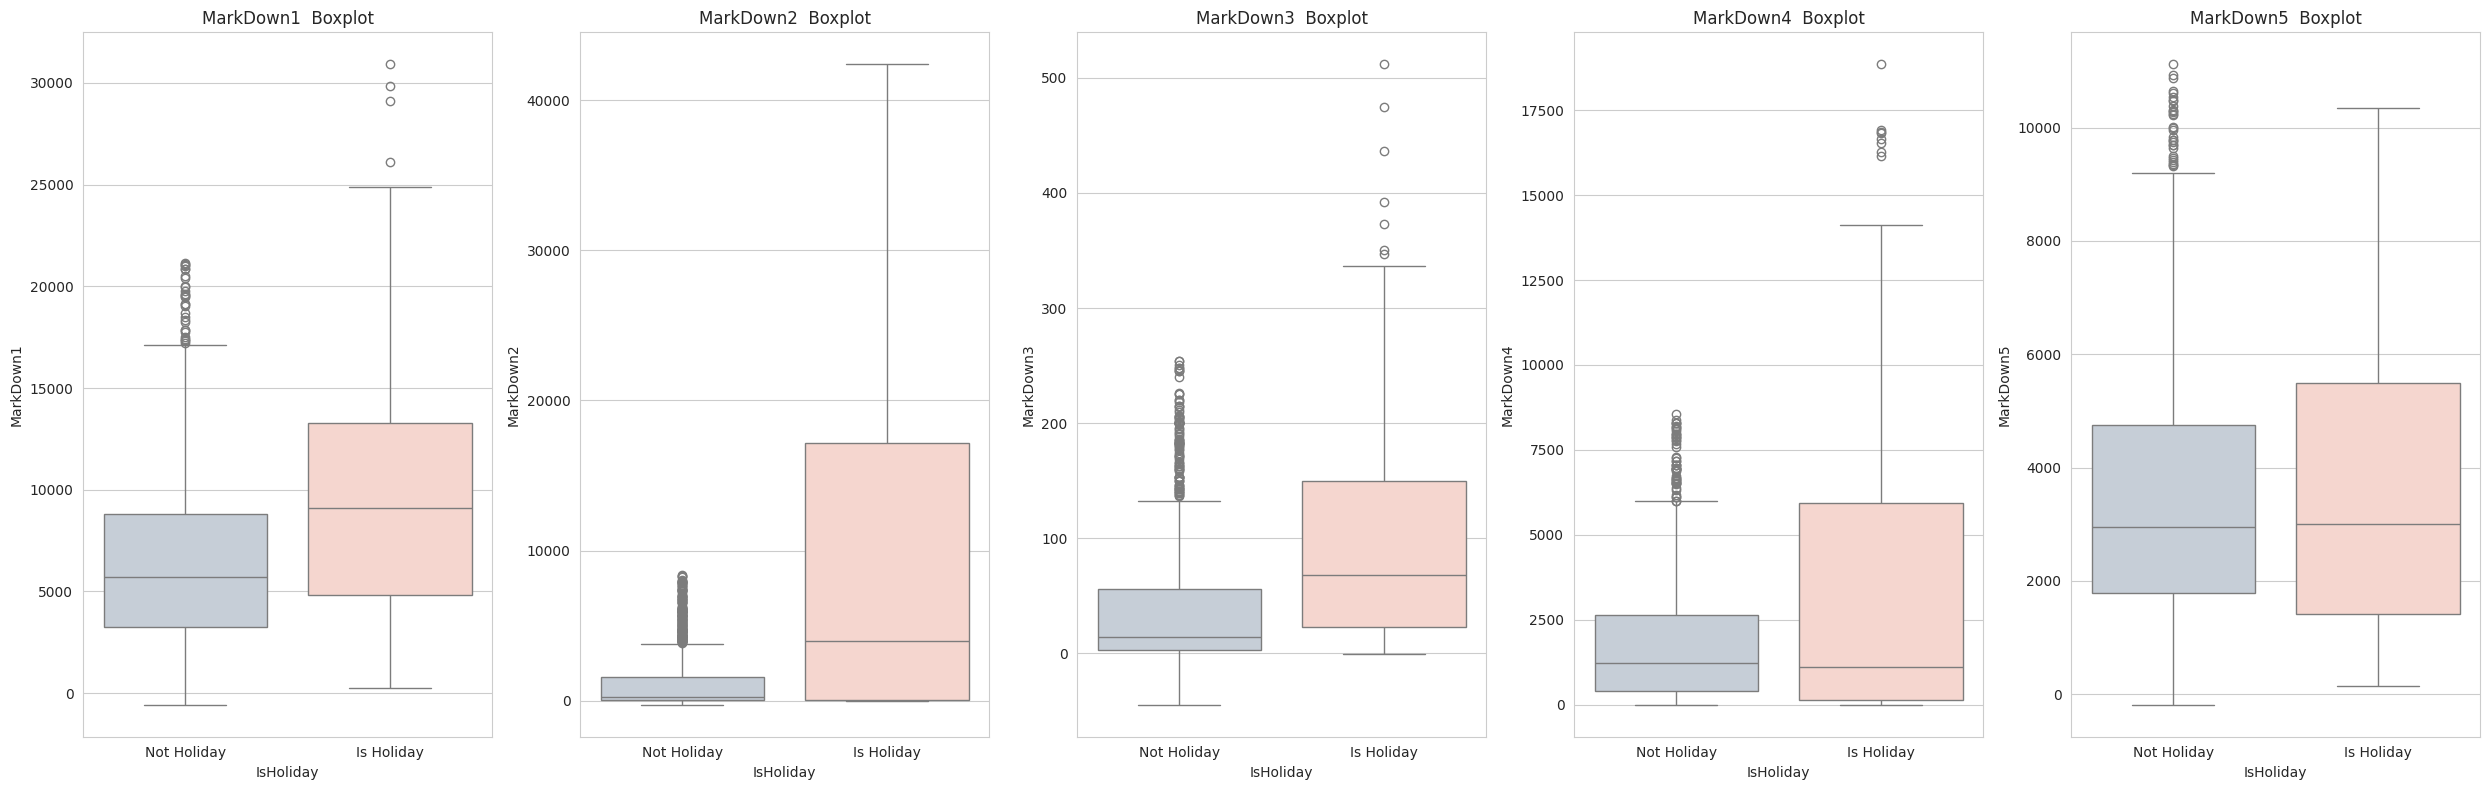

In [32]:
sns.set_style("whitegrid")
palette =  {'Not Holiday': "#c3ceda", 'Is Holiday': "#fbd2c9"}

fig, axes = plt.subplots(ncols=num_vars, figsize=(25, 8))


for i, col in enumerate(columns):
    sns.boxplot(data=aux, x='IsHoliday', y=col, ax=axes[i], palette=palette)
    axes[i].set_title(f'{col}  Boxplot')



plt.tight_layout()
plt.show()

In [33]:
columns_isHoliday = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'IsHoliday']

* Pairplot afther clenead dataset

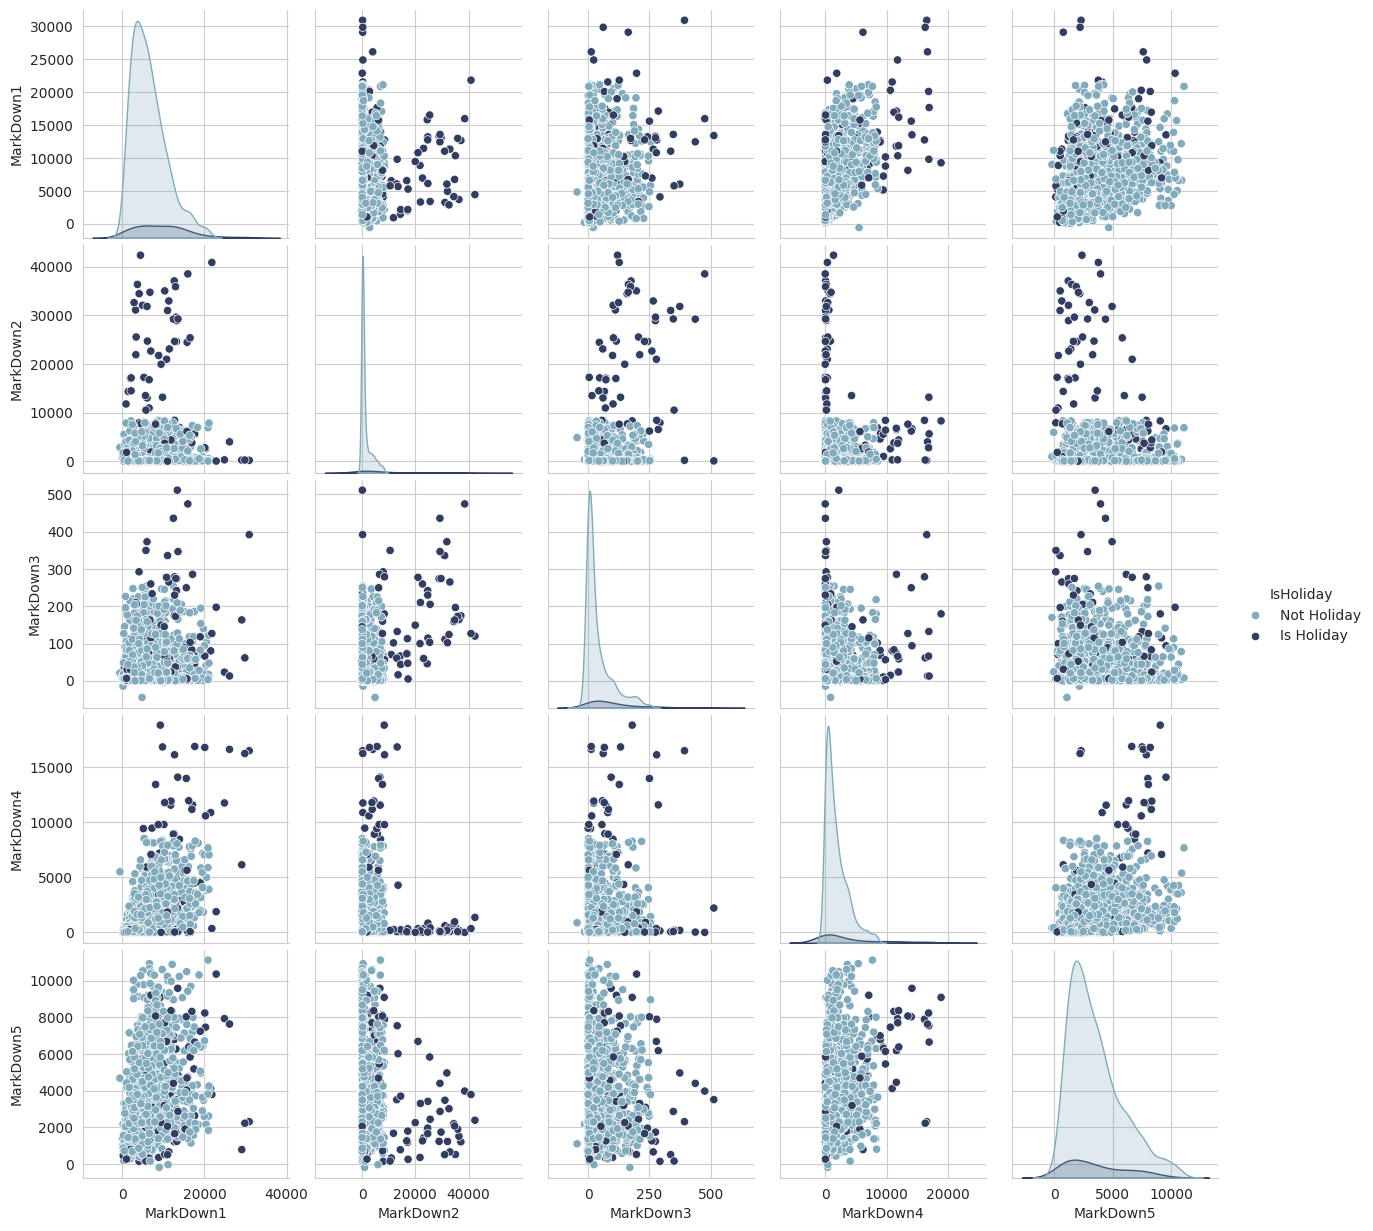

In [34]:
colors = ['#81abbc', '#313e61']
sns.set_style("whitegrid")
sns.pairplot(aux[columns_isHoliday], hue='IsHoliday', palette=colors)



---


In the boxplot, we can more clearly see that the features behave differently depending on whether it's a holiday or not. However, there appears to be no significant difference between the means of Markdown4 and Markdown5. Additionally, there are more outliers on non-holiday days. Lastly, the pairplot does not reveal a clear pattern.


---



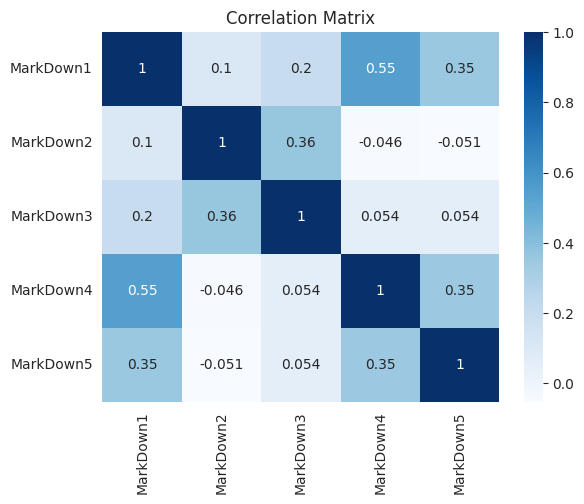

In [35]:
# Correlation
sns.heatmap(df[columns].corr(), annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()



---


Don't have any correlation between features.


---



### Model

The main idea is to create a classification model. The features are: Markdown 1, Markdown 2, Markdown 3rd, Markdown and Markdown, and the target is Holiday. At first, a logistic regression model is proposed because the target variable is binary.

#### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression


In [37]:
X = df[columns] # Features
y = df['IsHoliday'] # Traget

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1314 non-null   int64  
 1   IsHoliday  1314 non-null   bool   
 2   MarkDown1  1314 non-null   float64
 3   MarkDown2  1314 non-null   float64
 4   MarkDown3  1314 non-null   float64
 5   MarkDown4  1314 non-null   float64
 6   MarkDown5  1314 non-null   float64
dtypes: bool(1), float64(5), int64(1)
memory usage: 63.0 KB


In [39]:
y = y.apply(lambda x: 1 if x  else 0)

* Standardize features

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

* Train test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

* Model

In [42]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

* Metrics

In [43]:
from sklearn.metrics import accuracy_score, classification_report

In [44]:
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_matrix = cm(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


In [45]:
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9417721518987342
Confusion Matrix:
[[354   2]
 [ 21  18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       356
           1       0.90      0.46      0.61        39

    accuracy                           0.94       395
   macro avg       0.92      0.73      0.79       395
weighted avg       0.94      0.94      0.93       395





---


Although the accuracy indicates good model performance, the confusion matrix reveals a high number of false positives (Type I error). In conclusion, the model struggles to accurately classify holidays. To address this, cross-validation will be employed alongside ridge regression to identify which variables are most influencing the model, with the goal of reducing the number of false negatives.


---




* Ridge Regression

In [46]:
from sklearn.linear_model import Ridge

In [47]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

In [48]:
# Coefficients
coefficients = ridge.coef_

# Dataframe
coef_df = pd.DataFrame({
    'Variable': ['Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5'],
    'Coefficient': coefficients
})


# Order the variables by the magnitude of the coefficients
coef_df['abs_coef'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

coef_df

,Variable,Coefficient,abs_coef
1,Markdown2,0.147633,0.147633
3,Markdown4,0.098057,0.098057
2,Markdown3,0.025239,0.025239
4,Markdown5,-0.024630,0.024630
0,Markdown1,-0.002772,0.002772




---


Based on the above we can see that the most important variable in the model is “Markdown2” while the least important is “Markdown1”.

---



#### Logistic Regression without Markdown1

In [50]:
# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

param_grid = {
    'model__C': [0.001, 10, 100, 1000],  # Regulation values
    'model__penalty': ['l1', 'l2'], # Type of regulation
    'model__solver': ['liblinear', 'saga'], # Optimization algorithm


}

In [51]:
# Features
X_new = df[['MarkDown2', 'MarkDown3', 'MarkDown4',
            'MarkDown5']]
y = df['IsHoliday']
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

In [52]:
# Set up StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(pipeline,
                            param_grid=param_grid,
                            cv=stratified_kfold,
                            verbose=1,
                            n_jobs=-1,
                            scoring='roc_auc')

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters: {'model__C': 100, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best Score: 0.8248065432461553


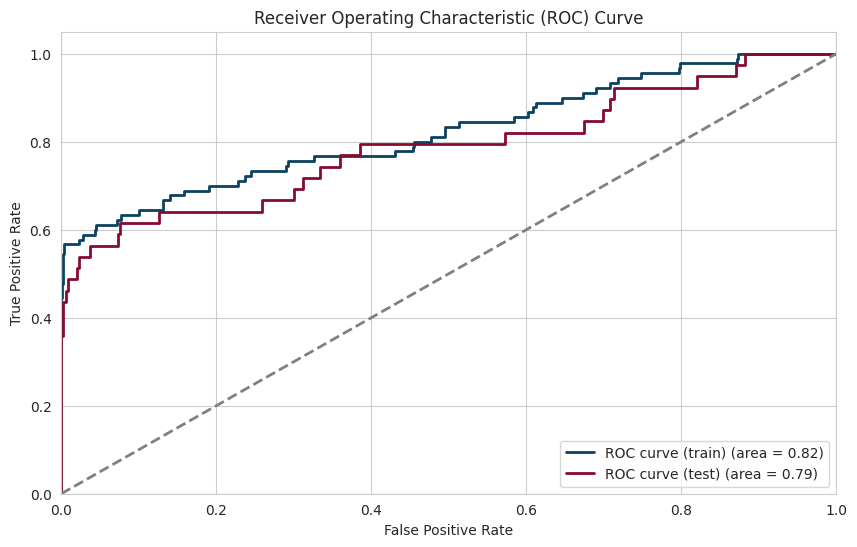

In [53]:
best_model = grid_search.best_estimator_

# Probabilistic predictions for training and test data
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve and AUC for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# ROC Graphs
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='#0c4160', lw=2, label=f'ROC curve (train) (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='#870a30', lw=2, label=f'ROC curve (test) (area = {roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

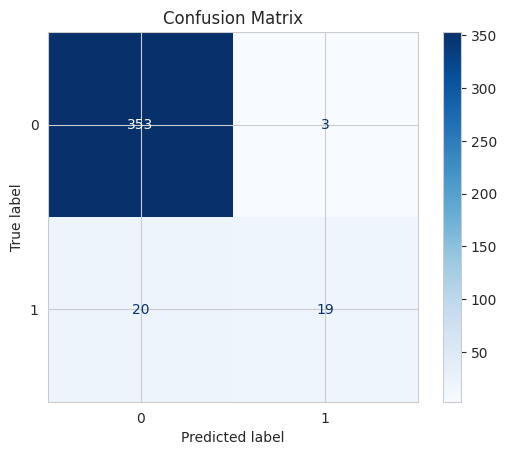

In [54]:
confusion_matrix = cm(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()



---

A logistic regression model with good performance has been developed. However, reaching this point required selecting different values for the `param_grid`, and it was observed that there was a significant improvement by selecting the variables: Markdown2, Markdown3, Markdown4, and Markdown5, while excluding Markdown1, which was shown to contribute the least to the model (according to Ridge regression). On the other hand, despite the good performance of the model, the reduction of Type 1 error was not achieved.

In terms of code, a pipeline was constructed, and cross-validation with StratifiedKFold was performed to ensure a balanced sample, all with the goal of obtaining a more robust model. It is noteworthy that GridSearchCV used 'roc_auc' as the scoring metric because specificity did not provide good metrics.

---

#### XGBoost

XGBoost (Extreme Gradient Boosting) is a machine learning algorithm based on the boosting method, which is widely used for classification and regression problems. XGBoost employs a gradient boosting approach, where models are built sequentially. Each new model corrects the errors of previous models, thereby improving the performance of the ense

In [55]:
# Data
X_new = markdowns_isHoliday[['MarkDown3', 'MarkDown2', 'MarkDown4', 'MarkDown5']]
y = markdowns_isHoliday['IsHoliday']


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

In [57]:
pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('model', xgb.XGBClassifier())
])

In [58]:

param_grid = {
    'model__max_depth': [3, 4],  # Use 'model__' to specify parameters for the XGBClassifier
    'model__eta': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 300]
}

# Set up StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(pipeline,
                            param_grid=param_grid,
                            cv=stratified_kfold, scoring='roc_auc')

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best parameters: {'model__eta': 0.2, 'model__max_depth': 3, 'model__n_estimators': 100}
Best Score: 0.8989797330696984


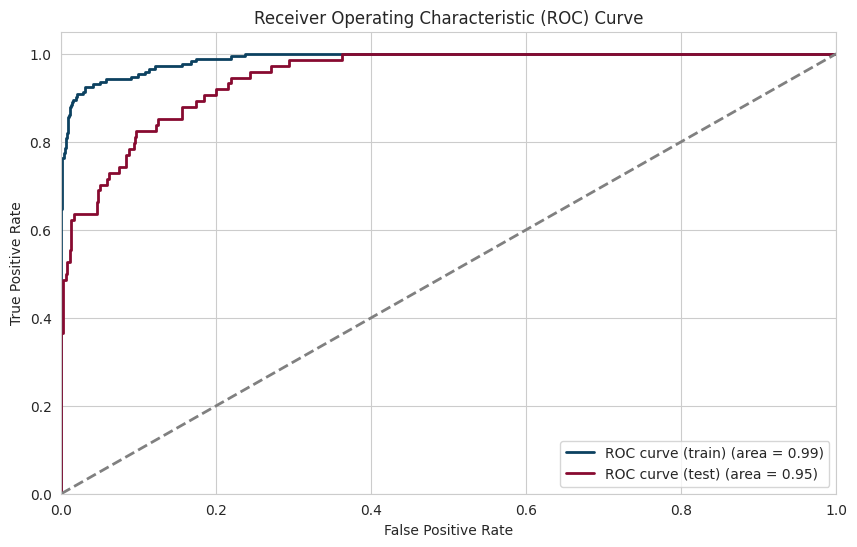

In [59]:
best_model = grid_search.best_estimator_

# Probabilistic predictions for training and test data
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve and AUC for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# ROC Graphs
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='#0c4160', lw=2, label=f'ROC curve (train) (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='#870a30', lw=2, label=f'ROC curve (test) (area = {roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

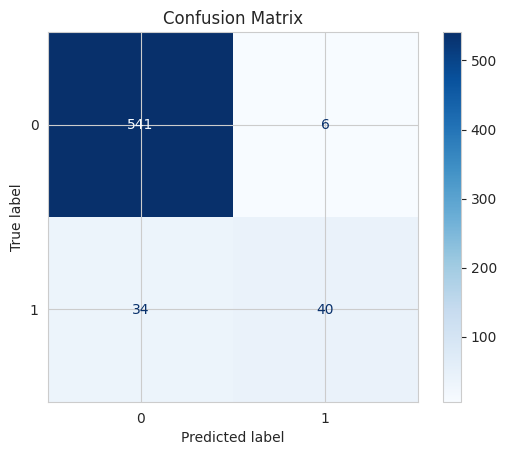

In [60]:
confusion_matrix = cm(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

---

As can be seen, the model shows good performance with an AUC of 0.99 for the training set, while the AUC of the test set is 0.95 (possibly due to a slight overfitting). However, there are still many false positives (type 1 error). In fact, if we compare the number of false positives and true negatives between this model and the previous one (Logistic Regression), the difference is not very significant. To solve this problem, more data may be needed. Another thing to take into account is that all data was used, which means that outliers were not eliminated, unlike the previous model.


---